# CPSC-5616EL: RNN vs LSTM vs GRU

This example code is focused on predicting airline passenger counts (many to one structure) using Vanilla RNN (Recurrent Neural Network), LSTM (Long Short-Term Memory), and models. It fetches data online, processes it, and uses both RNN and LSTM to make predictions. The dataset containing monthly airline passengers from 1949 to 1960 is downloaded from an online link "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv.

*Note: some of the code are generated using generative AI e.g. ChatGPT*

# Dataset Preparation
Preprocess time series data for training

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download and load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype(float)

# Normalize the dataset, scale the dataset to a range of [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Convert dataset into PyTorch tensors and reshapes the tensor to a 1D array
# to maintain a straightforward sequence of values without additional dimensions
# (one value per time step)
dataset = torch.FloatTensor(dataset).view(-1)

# Split data into train and test sets
train, test = train_test_split(dataset, test_size=0.2, shuffle=False)
# You can use TimeSeriesSplit to split a time series dataset into
# multiple train-test pairs for cross-validation

# means that each input sample consists of 3 time steps,
# which the model will use to predict the next step.
look_back = 3

# Convert time series data to RNN input/output pairs
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return torch.stack(dataX), torch.stack(dataY)


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


Using device: cuda


# Vanilla RNN

In [ ]:
# Model hyperparameters
input_size = 1 # univariate time series, input_size > 1 is you have more data for each time step
hidden_size = 32 # number of hidden neurons in each layer
num_layers = 1 # The number of stacked RNN layers, num_layers > 1 creates a Deep RNN
learning_rate = 0.001
num_epochs = 150

# RNN Model Definition
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:,-1,:]) # Extracts only the last state (-1) from the sequence, many to one structure
        return x

model = SimpleRNN(input_size, hidden_size, num_layers)
criterion = nn.MSELoss() # use Mean Squared Error Loss for regression, cross-entropy loss for classification
# Adam optimizer (adaptive learning rate based on learning momentum) is used instead of SGD
# Adam is more robust and usually faster to converge for deep networks : hidden_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training & Prediction
for epoch in range(num_epochs):
    # Forward pass:
    outputs = model(trainX.unsqueeze(-1))  # Predict using the model; unsqueeze(-1) adds an extra dimension to the data
    # Zero the gradients:
    optimizer.zero_grad()  # Clear accumulated gradients from previous iterations
    # Compute the loss:
    loss = criterion(outputs, trainY.unsqueeze(-1))  # Calculate the loss between the predictions and actual values
    # Backward pass:
    loss.backward()  # Compute gradients of the loss with respect to model parameters
    # Update model weights:
    optimizer.step()  # Perform a single optimization step to update the model's weights

    if (epoch+1) % 15 == 0: # in every 15 epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Test the model
model.eval()
test_outputs = model(testX.unsqueeze(-1))
test_outputs = test_outputs.detach().numpy()

# Invert predictions
test_outputs = scaler.inverse_transform(test_outputs)
actual = scaler.inverse_transform(testY.unsqueeze(-1).numpy())

Epoch 15/150, Loss: 0.0300
Epoch 30/150, Loss: 0.0219
Epoch 45/150, Loss: 0.0154
Epoch 60/150, Loss: 0.0089
Epoch 75/150, Loss: 0.0054
Epoch 90/150, Loss: 0.0051
Epoch 105/150, Loss: 0.0049
Epoch 120/150, Loss: 0.0048
Epoch 135/150, Loss: 0.0047
Epoch 150/150, Loss: 0.0046


# LSTM (Long Short-term Memory) Model

In [ ]:
# Model hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
learning_rate = 0.01
num_epochs = 150

# GRU Model Definition
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        return x

lstm_model = SimpleLSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train LSTM
for epoch in range(num_epochs):
    outputs = lstm_model(trainX.unsqueeze(-1))
    lstm_optimizer.zero_grad()
    loss = criterion(outputs, trainY.unsqueeze(-1))
    loss.backward()
    lstm_optimizer.step()
    if (epoch+1) % 15 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Test the LSTM model
lstm_model.eval()
lstm_test_outputs = lstm_model(testX.unsqueeze(-1))
lstm_test_outputs = lstm_test_outputs.detach().numpy()

# Invert LSTM predictions
lstm_test_outputs = scaler.inverse_transform(lstm_test_outputs)

Epoch 15/150, Loss: 0.0205
Epoch 30/150, Loss: 0.0057
Epoch 45/150, Loss: 0.0051
Epoch 60/150, Loss: 0.0045
Epoch 75/150, Loss: 0.0040
Epoch 90/150, Loss: 0.0036
Epoch 105/150, Loss: 0.0031
Epoch 120/150, Loss: 0.0027
Epoch 135/150, Loss: 0.0025
Epoch 150/150, Loss: 0.0024


# GRU (Gated Recurrent Unit)

In [ ]:
# Set GRU Hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
learning_rate = 0.01
num_epochs = 150

# GRU Model Definition
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x[:,-1,:])
        return x

gru_model = SimpleGRU(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

# Train GRU
for epoch in range(num_epochs):
    outputs = gru_model(trainX.unsqueeze(-1))
    gru_optimizer.zero_grad()
    loss = criterion(outputs, trainY.unsqueeze(-1))
    loss.backward()
    gru_optimizer.step()
    if (epoch+1) % 15 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
# Test the GRU Model
gru_model.eval()
gru_test_outputs = gru_model(testX.unsqueeze(-1))
gru_test_outputs = gru_test_outputs.detach().numpy()

# Invert GRU predictions
gru_test_outputs = scaler.inverse_transform(gru_test_outputs)

Epoch 15/150, Loss: 0.0100
Epoch 30/150, Loss: 0.0052
Epoch 45/150, Loss: 0.0040
Epoch 60/150, Loss: 0.0035
Epoch 75/150, Loss: 0.0032
Epoch 90/150, Loss: 0.0028
Epoch 105/150, Loss: 0.0026
Epoch 120/150, Loss: 0.0025
Epoch 135/150, Loss: 0.0024
Epoch 150/150, Loss: 0.0024


# Visualization

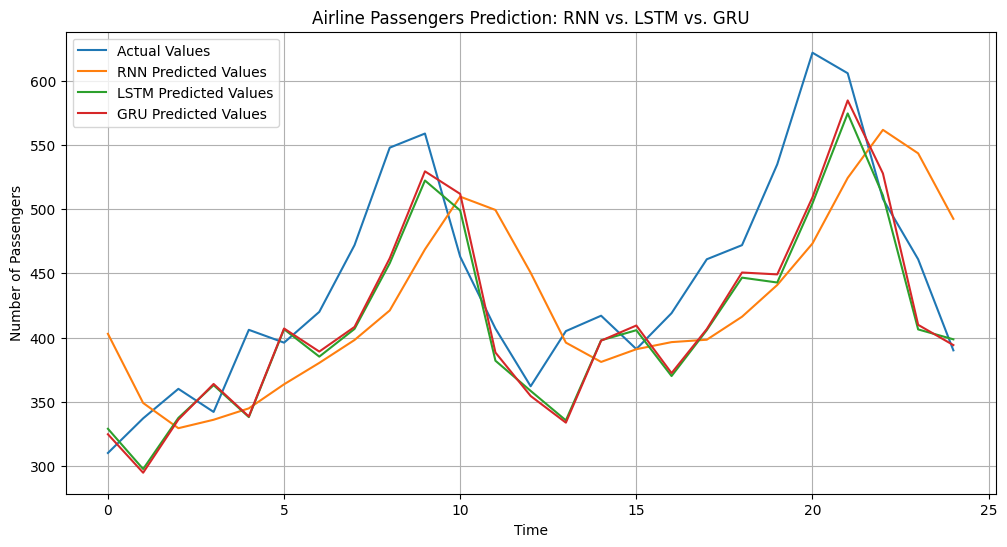

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual, label="Actual Values")
plt.plot(test_outputs, label="RNN Predicted Values")
plt.plot(lstm_test_outputs, label="LSTM Predicted Values")
plt.plot(gru_test_outputs, label="GRU Predicted Values")  # Add this line for GRU
plt.legend()
plt.title("Airline Passengers Prediction: RNN vs. LSTM vs. GRU")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.grid(True)
plt.show()